In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import h5py
import seaborn
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import pairwise_distances
import sys
sys.path.append("../")
from utils import l2_normalize, prewhiten, read_sampled_identities
from PIL import Image
seaborn.set()

In [73]:
def recall_given_dist(
    dist_self,
    dist_negative,
    k
):
    dist_self = np.sort(dist_self)
    dist_negative = np.sort(dist_negative)
    i = 0.0
    i_self = 0
    i_neg = 0
    recall_count = 0.0
    while i < k:  
        if dist_self[i_self] < dist_negative[i_neg]:
            recall_count += 1.0
            i_self += 1
        else:
            i_neg += 1

        i += 1.0

        if i_self >= len(dist_self):
            break

        if i_neg >= len(dist_negative):
            total_true = min(float(len(dist_self)), k - i)
            remaining_true = max(total_true - i_self, 0.0)
            recall_count += remaining_true
            break
    final = recall_count / min(len(dist_self), k)

    return final

def recall(
    base_embeddings, 
    negative_embeddings,
    k
):
    self_distances = pairwise_distances(
        base_embeddings,
        base_embeddings
    )
    
    negative_distances = pairwise_distances(
        base_embeddings,
        negative_embeddings
    )
    
    recall = []
    for indx, dist_self in enumerate(self_distances):
        dist_self = np.delete(dist_self, indx)
        dist_negative = negative_distances[indx]
        r = recall_given_dist(dist_self, dist_negative, k)
        recall.append(r)
    return np.mean(recall)

def recall_for_target(
    adversarial_target, 
    identities,
    epsilons, 
    path_to_adversarial, 
    path_to_clean,
    ks
):
    query_embeddings = []
    adv = {eps: [] for eps in epsilons}
    with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
        query_embeddings.extend(f["embeddings"][:])

    for modified_identity in identities:
        if modified_identity == adversarial_target:
            continue
        for indx, epsilon in enumerate(epsilons):
            if epsilon == 0.0:
                with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
                    adv[epsilon].extend(f["embeddings"][:])
            else:
                with h5py.File(path_to_adversarial.format(
                    target=adversarial_target,
                    true=modified_identity,
                    epsilon=epsilon
                ), "r") as f:
                    adv[epsilon].extend(f["embeddings"][:])
    
    return [[recall(query_embeddings, adv[epsilon], k) for epsilon in epsilons] for k in ks]
      

In [74]:
def plot_recall(
    path_to_adversarial="/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5",
    path_to_clean="/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5",
    epsilons=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1],
    identities=read_sampled_identities("../sampled_identities.txt").keys(),
    ks=[1, 5, 10, 100, 1000],
    colors=['#0017ad', '#2d67ed', '#37a0f0', '#37e6f0','#000000']
):
    recall_for_targets = np.ones((len(identities), len(ks), len(epsilons))) * (-1.0)
    
    for indx, identity in enumerate(identities):
        recall_for_targets[indx, :, :] = recall_for_target(
            identity,
            identities,
            epsilons,
            path_to_adversarial,
            path_to_clean,
            ks
        )
    
    recall_for_targets = np.mean(recall_for_targets, axis=0)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)

    for indx, k in enumerate(ks):
        ax.plot(
            list(epsilons),
            recall_for_targets[indx],
            label="k={}".format(k),
            color=colors[indx],
        )

    ax.set_ylabel("Recall Percentage")
    ax.set_xlabel("Epsilon (Perturbation Amount)")
    ax.set_title("Recall from top hits community_naive_same")
    ax.set_ylim([-0.1, 1.1])
    ax.legend()
    plt.show()
        

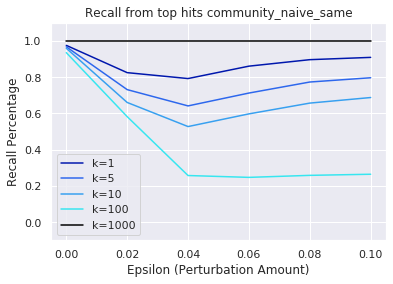

In [75]:
plot_recall()

# Tests for recall function

In [ ]:
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 100) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 100) == 1.0)
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 100) == 1.0)
print()
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 2) == 0.5)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [0.4, 1.6], 2) == 0.5)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 2) == 0.0)
print()
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 4) == 0.5)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [0.4, 1.6], 4) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 4) == 1.0)
print()
print(np.abs(recall_given_dist([0.0, 1.8], [1.5, 1.6], 3) - 0.5) < 1e-3)
print(np.abs(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3)) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.0], [0.4, 1.6], 3)) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 3) == 0.5)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 1) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.0], [0.4, 1.6], 1)) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 1) == 0.0)
print()
print(recall_given_dist([0.0, 0.1, 0.2], [0.3, 0.4, 0.5], 5) == 1.0)
print(np.abs(recall_given_dist([0.0, 0.1, 0.2, 0.3, 0.4], [0.5, 1.6], 5)) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.1, 0.2, 0.3, 0.4], [0.4, 1.6], 5)) == 0.8)
print()
print(recall_given_dist([0.0, 0.1, 0.2], [0.3, 0.4, 0.5], 1) == 1.0)
print(np.abs(recall_given_dist([0.0, 0.1, 0.2, 0.3, 0.4], [0.5, 1.6], 1)) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.1, 0.2, 0.3, 0.4], [0.4, 1.6], 1)) == 1.0)

In [91]:
def debug_recall(
    adversarial_target="n000029",
    epsilon=0.0,
    k=5
):
    path_to_adversarial="/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5"
    path_to_clean="/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5"
    
    query_embeddings = []
    adv = {eps: [] for eps in epsilons}
    identities=read_sampled_identities("../sampled_identities.txt").keys()

    with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
        query_embeddings.extend(f["embeddings"][:])

    for modified_identity in identities:
        if modified_identity == adversarial_target:
            continue
        with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
            adv[epsilon].extend(f["embeddings"][:])
        
    self_distances = pairwise_distances(query_embeddings)
    negative_distances = pairwise_distances(query_embeddings, adv[epsilon])
    
    n_clean = len(query_embeddings)
    n_rows = int(np.sqrt(n_clean))
    fig, ax = plt.subplots(ncols=n_rows, nrows=n_rows+1, figsize=(30, 30))
    for indx in range(n_clean):
        dist_self = np.sort(np.delete(self_distances, indx))[:k]
        dist_neg = np.sort(negative_distances[indx])[:k]
        row = indx // n_rows
        col = indx % n_rows
        ax[row][col].plot(range(k), dist_self, 'go')
        ax[row][col].plot(range(k), dist_neg, 'ro')
        ax[row][col].set_ylabel("Distance to image".format(indx))
        ax[row][col].set_xlabel("Top nth image")
        ax[row][col].set_title("eps = k = {} indx = {}".format(k, indx))
        ax[row][col].set_ylim([-0.1, 1.2])
    fig.tight_layout(pad=3.0)
    plt.show()
    


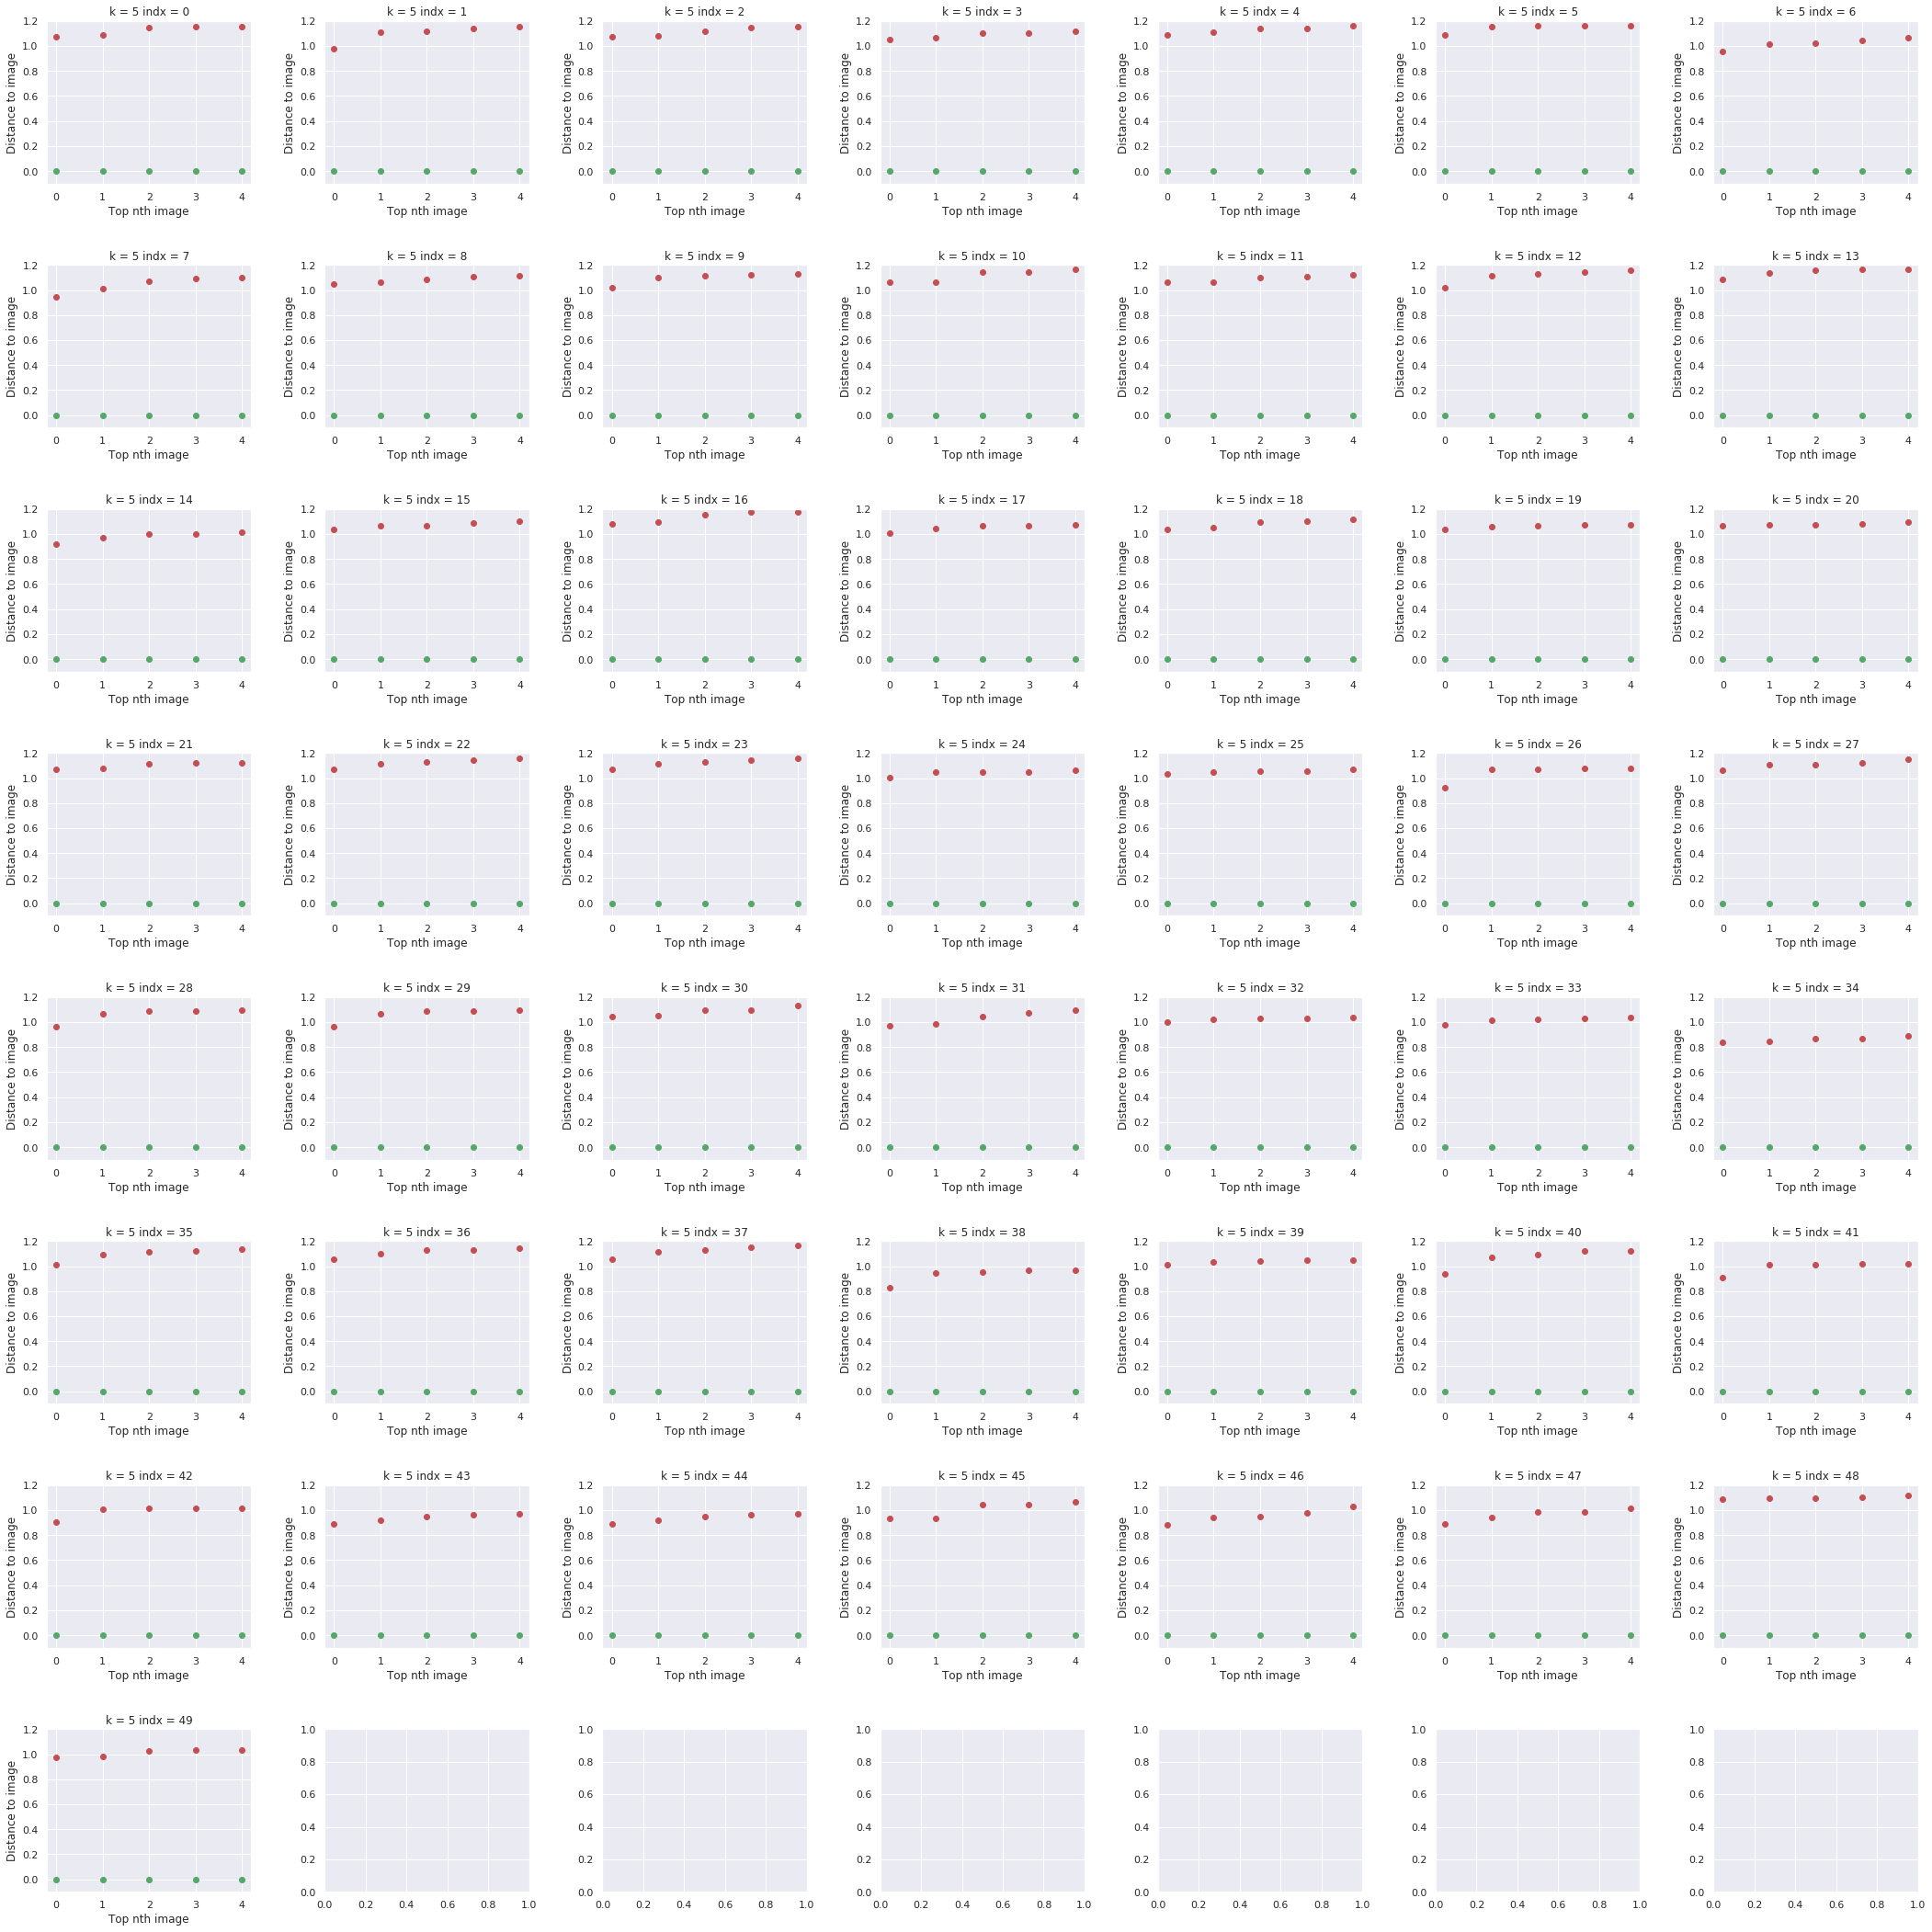

In [92]:
debug_recall()

In [24]:
a, b = debug_recall()

In [38]:
k = 5
for eps in [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]:
    c = pairwise_distances(a, b[eps])[0]
    d = pairwise_distances(a, a)[0]
    print(eps)
    print("top 5 positives"," ".join(["{:.2E}".format(x) for x in np.sort(d)[:k]]))
    print("top 5 negatives", " ".join(["{:.2E}".format(x) for x in np.sort(c)[:k]]))
    print()

0.0
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01
top 5 negatives 1.07E+00 1.09E+00 1.14E+00 1.15E+00 1.15E+00

0.02
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01
top 5 negatives 4.21E-01 4.22E-01 4.42E-01 4.86E-01 4.93E-01

0.04
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01
top 5 negatives 1.02E-01 1.06E-01 1.08E-01 1.08E-01 1.08E-01

0.06
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01
top 5 negatives 2.96E-02 3.32E-02 3.66E-02 3.79E-02 3.85E-02

0.08
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01
top 5 negatives 2.09E-02 2.18E-02 2.26E-02 2.28E-02 2.31E-02

0.1
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01
top 5 negatives 1.82E-02 1.92E-02 1.98E-02 2.00E-02 2.01E-02



In [37]:
k = 10
for eps in [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]:
    c = pairwise_distances(a, b[eps])[0]
    d = pairwise_distances(a, a)[0]
    print(eps)
    print("top 5 positives"," ".join(["{:.2E}".format(x) for x in np.sort(d)[:k]]))
    print("top 5 negatives", " ".join(["{:.2E}".format(x) for x in np.sort(c)[:k]]))
    print()

0.0
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01 6.38E-01 6.42E-01 6.69E-01 6.79E-01 6.80E-01
top 5 negatives 1.07E+00 1.09E+00 1.14E+00 1.15E+00 1.15E+00 1.16E+00 1.16E+00 1.17E+00 1.17E+00 1.18E+00

0.02
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01 6.38E-01 6.42E-01 6.69E-01 6.79E-01 6.80E-01
top 5 negatives 4.21E-01 4.22E-01 4.42E-01 4.86E-01 4.93E-01 5.20E-01 5.42E-01 5.47E-01 5.61E-01 5.81E-01

0.04
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01 6.38E-01 6.42E-01 6.69E-01 6.79E-01 6.80E-01
top 5 negatives 1.02E-01 1.06E-01 1.08E-01 1.08E-01 1.08E-01 1.10E-01 1.18E-01 1.24E-01 1.34E-01 1.35E-01

0.06
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01 6.38E-01 6.42E-01 6.69E-01 6.79E-01 6.80E-01
top 5 negatives 2.96E-02 3.32E-02 3.66E-02 3.79E-02 3.85E-02 3.96E-02 3.97E-02 4.07E-02 4.24E-02 4.31E-02

0.08
top 5 positives 2.98E-08 5.60E-01 6.05E-01 6.11E-01 6.29E-01 6.38E-01 6.42E-01 6.69E-01 6.79E-01 6.80E-01
top 5 negatives 2.

In [66]:
recall(a, b[0.0], 5)

self disttances shape (50, 50)
negative_distances shape (50, 900)
dist_self shape (49,)
dist_negative shape (900,)
k 5 indx 0
top 5 positives 5.60E-01 6.05E-01 6.11E-01 6.29E-01 6.38E-01
top 5 negatives 1.07E+00 1.09E+00 1.14E+00 1.15E+00 1.15E+00
computed recall 1.0
dist_self shape (49,)
dist_negative shape (900,)
k 5 indx 1
top 5 positives 6.96E-01 7.32E-01 7.32E-01 7.40E-01 7.71E-01
top 5 negatives 9.79E-01 1.11E+00 1.12E+00 1.14E+00 1.16E+00
computed recall 1.0
dist_self shape (49,)
dist_negative shape (900,)
k 5 indx 2
top 5 positives 4.60E-01 4.77E-01 5.19E-01 5.20E-01 5.30E-01
top 5 negatives 1.08E+00 1.08E+00 1.12E+00 1.14E+00 1.15E+00
computed recall 1.0
dist_self shape (49,)
dist_negative shape (900,)
k 5 indx 3
top 5 positives 5.47E-01 5.70E-01 5.71E-01 5.73E-01 5.74E-01
top 5 negatives 1.05E+00 1.07E+00 1.10E+00 1.11E+00 1.12E+00
computed recall 1.0
dist_self shape (49,)
dist_negative shape (900,)
k 5 indx 4
top 5 positives 5.20E-01 5.47E-01 6.01E-01 6.02E-01 6.31E-01
top 5

0.9479999999999998

In [59]:
recall(a, b[0.02], 10)

k 10 indx 0
top 5 positives 5.60E-01 6.05E-01 6.11E-01 6.29E-01 6.38E-01 6.42E-01 6.69E-01 6.79E-01 6.80E-01 6.89E-01
top 5 negatives 4.21E-01 4.22E-01 4.42E-01 4.86E-01 4.93E-01 5.20E-01 5.42E-01 5.47E-01 5.61E-01 5.81E-01
computed recall 0.1
k 10 indx 1
top 5 positives 6.96E-01 7.32E-01 7.32E-01 7.40E-01 7.71E-01 7.78E-01 7.78E-01 7.83E-01 8.29E-01 8.41E-01
top 5 negatives 8.34E-01 8.62E-01 8.64E-01 8.64E-01 8.72E-01 8.72E-01 8.73E-01 8.76E-01 8.82E-01 8.84E-01
computed recall 0.9
k 10 indx 2
top 5 positives 4.60E-01 4.77E-01 5.19E-01 5.20E-01 5.30E-01 5.45E-01 5.51E-01 5.61E-01 5.88E-01 5.91E-01
top 5 negatives 7.05E-01 7.33E-01 7.34E-01 7.35E-01 7.38E-01 7.43E-01 7.50E-01 7.60E-01 7.60E-01 7.64E-01
computed recall 1.0
k 10 indx 3
top 5 positives 5.47E-01 5.70E-01 5.71E-01 5.73E-01 5.74E-01 5.79E-01 5.83E-01 5.95E-01 6.11E-01 6.44E-01
top 5 negatives 6.80E-01 6.98E-01 7.19E-01 7.21E-01 7.22E-01 7.23E-01 7.28E-01 7.29E-01 7.38E-01 7.40E-01
computed recall 1.0
k 10 indx 4
top 5 positi

0.7040000000000001

In [42]:
recall(a, b[0.04], 5)

0.6679999999999999

In [43]:
recall(a, b[0.06], 5)

0.7319999999999999

In [64]:
recall(a, b[0.08], 10)

self disttances shape (50, 50)
negative_distances shape (50, 900)
dist_self shape [0.88595647 0.6382649  0.61127615 0.695172   0.6889584  0.73876864
 0.66897607 0.85176176 0.5600929  0.70037246 0.804073   0.62887347
 0.7333476  0.76861745 0.81511116 0.67850405 0.7659386  0.8512329
 0.7984972  0.854379   0.6796185  0.7422929  0.7422929  0.8243096
 1.1778108  0.98952997 0.7473898  0.8556237  0.8556237  0.75077003
 0.9236357  0.7790206  1.0232841  1.0632529  0.8554175  0.6423476
 0.794186   1.1979688  0.9387306  0.96671814 1.0085776  1.0085776
 0.8408058  0.8408058  1.0413684  0.9775648  0.91223043 0.60451823
 1.0183533 ]
dist_negative shape [0.51557904 0.1344929  0.10239705 0.45486313 0.25278583 0.05988542
 0.4990032  0.5743074  0.37521687 0.0774539  0.04063085 0.03884
 0.12495812 0.43736714 0.4559466  0.19909254 0.3885549  0.18912545
 0.5006765  0.28755182 0.47588632 0.45344365 0.45695412 0.14283362
 0.4360165  0.41024476 0.3844418  0.41211307 0.41208068 0.08334784
 0.12128001 0.1310527

dist_negative shape [1.1916393 1.0612453 1.0490271 1.1466434 1.0140926 1.0602363 1.1720573
 1.1776359 1.1298467 1.0576617 1.0564693 1.0617033 1.0616162 1.1497272
 1.1780552 1.0417274 1.1601824 1.1085443 1.179423  1.1415825 1.1705209
 1.1714942 1.1653625 1.0484195 1.1374648 1.168019  1.1555235 1.1723202
 1.1764104 1.0632007 1.0572596 1.0600318 1.1825731 1.2470995 1.0569812
 1.1083773 1.1855937 1.0561719 1.0441109 1.0618788 1.0591731 1.0645089
 1.0846226 1.1510767 1.0592406 1.1934695 1.1730884 1.1241184 1.1509467
 1.1227344 1.0578943 1.0606441 1.0532651 1.0488487 1.0613914 1.0569962
 1.0624306 1.0661584 1.0409107 1.0588428 1.0646119 1.0698899 1.0527356
 1.0569059 1.0618324 1.0647902 1.0657637 1.0640414 1.0512803 1.0599746
 1.0551641 1.0328203 1.0647012 1.0587232 1.053618  1.057811  1.0568061
 1.0536859 1.0540802 1.0531341 1.0653762 1.0475743 1.0490873 1.0604727
 1.0613917 1.0591502 1.0630684 1.050945  1.0637618 1.0580742 1.0576237
 1.0576606 1.0562963 1.0620142 1.0643693 1.0608422 1.0670

0.6779999999999999

In [58]:
recall_given_dist(
    [2.11E-08, 7.08E-01, 7.16E-01, 7.28E-01, 7.63E-01], 
    [7.99E-01, 8.00E-01, 8.05E-01, 8.09E-01, 8.10E-01], 
    5
)

1.0

In [62]:
recall(a, b[0.08], 5)

k 5 indx 0
top 5 positives 5.60E-01 6.05E-01 6.11E-01 6.29E-01 6.38E-01
top 5 negatives 2.09E-02 2.18E-02 2.26E-02 2.28E-02 2.31E-02
computed recall 0.0
k 5 indx 1
top 5 positives 6.96E-01 7.32E-01 7.32E-01 7.40E-01 7.71E-01
top 5 negatives 8.52E-01 8.57E-01 8.63E-01 8.65E-01 8.66E-01
computed recall 1.0
k 5 indx 2
top 5 positives 4.60E-01 4.77E-01 5.19E-01 5.20E-01 5.30E-01
top 5 negatives 5.60E-01 5.84E-01 6.13E-01 6.14E-01 6.15E-01
computed recall 1.0
k 5 indx 3
top 5 positives 5.47E-01 5.70E-01 5.71E-01 5.73E-01 5.74E-01
top 5 negatives 5.95E-01 5.97E-01 5.99E-01 5.99E-01 6.00E-01
computed recall 1.0
k 5 indx 4
top 5 positives 5.20E-01 5.47E-01 6.01E-01 6.02E-01 6.31E-01
top 5 negatives 6.38E-01 6.48E-01 6.68E-01 6.74E-01 6.75E-01
computed recall 1.0
k 5 indx 5
top 5 positives 4.60E-01 5.58E-01 5.70E-01 6.08E-01 6.20E-01
top 5 negatives 6.06E-01 6.25E-01 6.57E-01 6.59E-01 6.59E-01
computed recall 0.8
k 5 indx 6
top 5 positives 5.03E-01 5.05E-01 5.79E-01 5.88E-01 5.90E-01
top 5 nega

0.796

In [45]:
recall(a, b[0.1], 5)

0.836